In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt

from scipy.stats import sem, t
from scipy import mean

In [ ]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class BayesNN:
  def __init__(self, k=3):
        self.k = k
  
  def get_params(self, deep=True):
    return {"k": self.k}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self
      
  def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self._classes = np.unique(y)

  def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
  
  def _predict(self, x):
        posteriors = []
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_idx = np.argsort(distances)[:self.k]
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        for idx, c in enumerate(self._classes):
            kj = k_neighbor_labels.count(idx)
            posterior = kj/self.k
            posteriors.append(posterior)
        return np.argmax(posteriors)

  def predictProb(self, X):
        prob = [self._predictProb(x) for x in X]
        return np.array(prob)
  
  def _predictProb(self, x):
        posteriors = []
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_idx = np.argsort(distances)[:self.k]
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        for idx, c in enumerate(self._classes):
            kj = k_neighbor_labels.count(idx)
            posterior = kj/self.k
            posteriors.append(posterior)
        return posteriors

In [ ]:
def predictSoma(pred, X_test1, y_test):
    soma = []
    p = []
    sum = 0
    y_pred = []
    _classes = np.unique(y)
    priors = []
    for x in range (len(X_test1)):
      for idx, c in enumerate(_classes):
          nj = np.count_nonzero(y_test == idx)
          priori = nj/len(y_test)
          priors.append(priori)
          for clf in range(3):
            sum = sum + pred[x][clf][idx]
          soma.append(sum)
          sum = 0
          aux = ((1-3)*priors[idx] + soma[idx])
          p.append(aux)
      soma=[]
      y_pred.append(np.argmax(p))
      p=[]
    return np.array(y_pred)

In [ ]:
view1 = pd.read_csv('https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-fac.csv', header = None, delim_whitespace=True)
view2 = pd.read_csv('https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-fou.csv', header = None, delim_whitespace=True)
view3 = pd.read_csv('https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-kar.csv', header = None, delim_whitespace=True)

target = pd.read_csv('https://raw.githubusercontent.com/jsaj/MachineLearning/master/cluster_membership_tres_m.csv', header = None, delim_whitespace=True)

view1 = preprocessing.normalize(view1, 'max')
view2 = preprocessing.normalize(view2, 'max')
view3 = preprocessing.normalize(view3, 'max')

X1 = view1
X2 = view2
X3 = view3

y = np.array(target.values).T[0]

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split (X1,y)
X_train2, X_test2, y_train2, y_test2 = train_test_split (X2,y)
X_train3, X_test3, y_train3, y_test3 = train_test_split (X3,y)

Xtrain = [X_train1, X_train2, X_train3]
ytrain = [y_train1, y_train2, y_train3]

Score:  0.8266666666666667
O K ótimo é 7


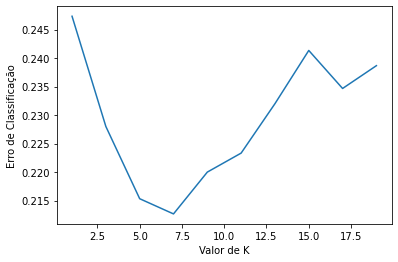

Score:  0.7066666666666667
O K ótimo é 13


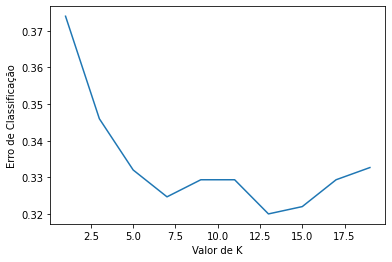

Score:  0.8
O K ótimo é 5


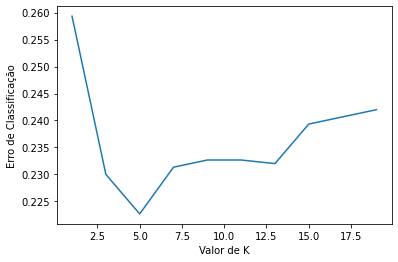

In [ ]:
neighbors = list(range(1, 20, 2))

K = []
for i in range (len(Xtrain)): 
  cv_scores = []
  for k in neighbors:
      bnn = BayesNN(k=k)
      scores = cross_val_score(bnn, Xtrain[i], ytrain[i], cv=10, scoring='accuracy')
      cv_scores.append(scores.mean())
      
  mse = [1 - x for x in cv_scores]
  print ("Score: ", max(scores))

  # determina o melhor k
  optimal_k = neighbors[mse.index(min(mse))]
  print("O K ótimo é {}".format(optimal_k))
  K.append(optimal_k)

  # plot erro de classificação vs k
  plt.plot(neighbors, mse)
  plt.xlabel("Valor de K")
  plt.ylabel("Erro de Classificação")
  plt.show()

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30)
scores = []

for train_index, test_index in rskf.split(X1,y):
    X_train1, X_test1 = X1[train_index], X1[test_index]
    X_train2, X_test2 = X2[train_index], X2[test_index]
    X_train3, X_test3 = X3[train_index], X3[test_index]
    
    y_train, y_test = y[train_index], y[test_index]
    
    model1 = BayesNN(K[0])
    model2 = BayesNN(K[1])
    model3 = BayesNN(K[2])

    model1.fit (X_train1, y_train) 
    model2.fit (X_train2, y_train) 
    model3.fit (X_train3, y_train) 

    pred1 = model1.predictProb(X_test1) 
    pred2 = model2.predictProb(X_test2) 
    pred3 = model3.predictProb(X_test3)
    pred = [[pred1[x], pred2[x], pred3[x]]  for x in range (len(X_test1))]

    y_pred = predictSoma(pred, X_test1, y_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

In [ ]:
print(scores)

[0.8, 0.81, 0.805, 0.765, 0.855, 0.83, 0.825, 0.86, 0.79, 0.79, 0.815, 0.76, 0.84, 0.795, 0.81, 0.86, 0.8, 0.83, 0.855, 0.815, 0.835, 0.81, 0.77, 0.81, 0.825, 0.795, 0.825, 0.825, 0.785, 0.84, 0.8, 0.825, 0.805, 0.81, 0.88, 0.8, 0.815, 0.805, 0.81, 0.835, 0.805, 0.79, 0.835, 0.805, 0.775, 0.815, 0.82, 0.785, 0.815, 0.85, 0.825, 0.775, 0.81, 0.805, 0.775, 0.83, 0.845, 0.81, 0.825, 0.79, 0.84, 0.825, 0.785, 0.815, 0.815, 0.775, 0.78, 0.825, 0.865, 0.825, 0.805, 0.87, 0.825, 0.77, 0.77, 0.835, 0.805, 0.82, 0.825, 0.805, 0.815, 0.8, 0.785, 0.815, 0.81, 0.79, 0.85, 0.825, 0.805, 0.79, 0.81, 0.775, 0.815, 0.845, 0.805, 0.8, 0.8, 0.805, 0.81, 0.87, 0.79, 0.83, 0.76, 0.8, 0.795, 0.85, 0.785, 0.81, 0.815, 0.825, 0.8, 0.795, 0.83, 0.86, 0.81, 0.77, 0.74, 0.84, 0.845, 0.835, 0.815, 0.855, 0.765, 0.83, 0.795, 0.805, 0.83, 0.785, 0.825, 0.85, 0.795, 0.84, 0.805, 0.805, 0.755, 0.79, 0.825, 0.835, 0.835, 0.855, 0.825, 0.795, 0.815, 0.825, 0.785, 0.745, 0.86, 0.8, 0.82, 0.86, 0.815, 0.805, 0.815, 0.78

In [ ]:
confidence = 0.95

n = len(scores)
m = mean(scores)
std_err = sem(scores)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

print("Média", m)
print("Erro Padrão", std_err)
start = m - h
end = m + h
print("Intervalo de confiança", start, end)

Média 0.8130833333333334
Erro Padrão 0.0015215762109528526
Intervalo de confiança 0.8100889783640552 0.8160776883026115


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  after removing the cwd from sys.path.
